# Predicting the Stock Market

In [2]:
import datetime as dt # allows us to specify time 
import matplotlib.pyplot as plt # plotting module 
from matplotlib import style # changes the sytles of our plot
import pandas as pd
import pandas_datareader.data as web
from numpy import*
import seaborn as sns

In [3]:
style.use('ggplot')
start = dt.datetime(2018,1,1)
end = dt.datetime(2019,5,20)
df = web.DataReader('TSLA','yahoo',start,end)
df.to_csv('tsla.csv')
df = pd.read_csv('tsla.csv',parse_dates = True)#index_col = 0)
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-01-02,322.109985,311.000000,312.000000,320.529999,4352200,320.529999
1,2018-01-03,325.250000,315.549988,321.000000,317.250000,4521500,317.250000
2,2018-01-04,318.549988,305.679993,312.869995,314.619995,9946300,314.619995
3,2018-01-05,317.239990,312.000000,316.619995,316.579987,4591200,316.579987
4,2018-01-08,337.019989,315.500000,316.000000,336.410004,9859400,336.410004


# Correlation Between Parameters

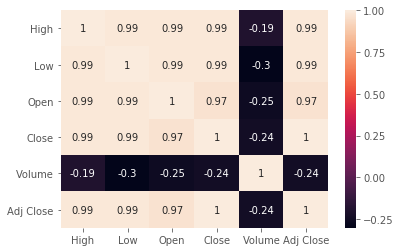

In [4]:

w = sns.heatmap(
    df.loc[:,['Date','High','Low','Open','Close','Volume','Adj Close']].corr(),
    annot=True
)

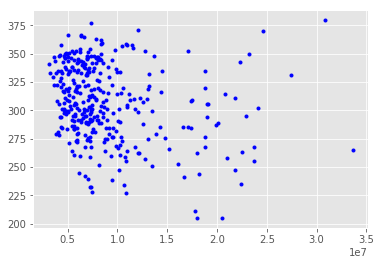

In [5]:
plt.plot(df['Volume'],df['Close'],'b.')

## Doing a Linear Regression on Stock Volitlity

In [6]:
percentage = (df['Open']-df['Close'])/df['Open']# calculating precentage change from Open to close

In [7]:
percentage.describe()

count    348.000000
mean      -0.000723
std        0.027641
min       -0.135137
25%       -0.016230
50%       -0.001161
75%        0.015155
max        0.081792
dtype: float64

In [8]:
std_mean_ratio = percentage.std()/percentage.mean()
std_mean_ratio

-38.24409004026746

In [9]:
count = percentage.count()
days = array(range(1,count + 1))

In [10]:
def linreg(y):
    ybar = y.mean()
    y2bar = (y**2).mean()
    xbar = days.mean()
    x2bar = (days**2).mean()
    xybar = (y*days).mean()
    A = array([[1,xbar],[xbar, x2bar]])
    b = array([ybar, xybar])
    w0,w1 = linalg.solve(A,b)
    n = w0 + w1*days
    print("correlation coefficient:",w1)
    print("starting point:",w0)
    return (n)
f = linreg(percentage)

correlation coefficient: 7.511255211602875e-06
starting point: -0.0020334586170537455


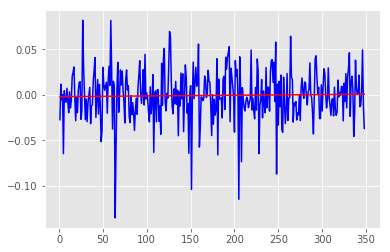

In [11]:
plt.plot(days, percentage,'b')# plotting precentage change
plt.plot(days, f,'r')

Looking a the precentage change over the year we can see that despite teslas volitilty they have been able to keep their stock price around zero with the average of $-.0009%$ This means that 

## Linear Regression of stock opening

In [12]:
Openprice = df["Open"]
fprime = linreg(Openprice)

correlation coefficient: -0.13832748572795456
starting point: 331.8115371412967


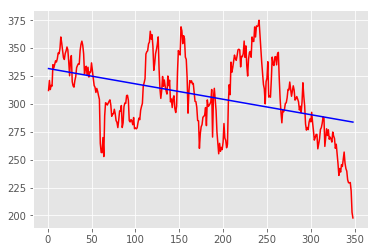

In [13]:
plt.plot(days,Openprice,'r');
plt.plot(days,fprime,'b');

In [14]:
(0.00798395479196507*(count+1))+0.3203636961848021

3.1067639185806115

# Stock Markets Using Neural Networks 

In [15]:
from sklearn.neural_network import MLPRegressor

In [16]:
volume = df['Volume']
X = array([Openprice,volume])
y = [0,1]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

NameError: name 'MLPClassifier' is not defined

In [ ]:
clf.fit(X,y)

In [ ]:
clf.predict(X+1)

# Calculationg and Graphin a Moving Average

In [18]:
df['100ma'] = df['Adj Close'].rolling(window = 100, min_periods = 0).mean()

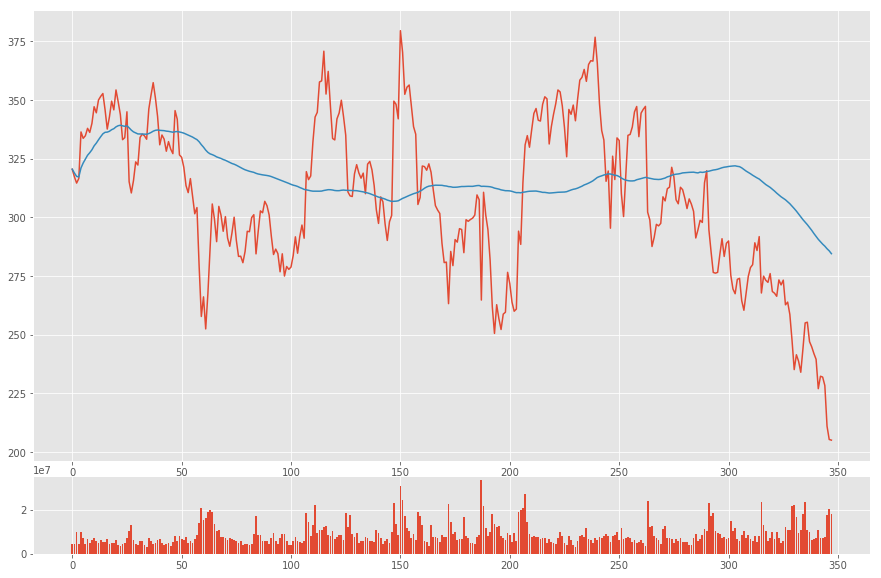

In [19]:
plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=2, colspan=3,sharex=ax1)
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])

plt.show()

# Web Scraping for Stocks

In [ ]:
import bs4 as bs
import os
import pickle
import requests

In [ ]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(tickers,f)
    print(tickers)
    
    return(tickers)
#save_sp500_tickers()

In [ ]:
def get_data_from_yahoo(reload_sp500 = False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle','rb') as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    start = dt.datetime(2010,1,1)
    end = dt.datetime.now()
    # just in case your connection breaks, we'd like to save our progress!
    if not os.path.exists('stock_dfs/{}.csv',format(ticker)):
        df = web.DataReader(ticker, 'morningstar', start, end)
        df.reset